In [1]:
import os

# Get the current working directory
current_dir = os.getcwd()

# Change to root direction
parent_dir = os.path.dirname(current_dir)
root_dir = os.path.dirname(parent_dir)
os.chdir(root_dir)

print(os.getcwd())

/Users/q661583/Code/mt_pref_memory_structured


In [8]:
import argparse
import configparser
import json
import pandas as pd
import tiktoken
import re

import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('punkt_tab')

from nltk.tokenize import sent_tokenize

config = configparser.ConfigParser()
config.read('config/config.ini')

df_user_level = pd.DataFrame()
df_conversation_level = pd.DataFrame()

encoding = tiktoken.get_encoding("cl100k_base")

# read out train dataset
train_dataset_lines = []
with open("dataset/dataset/dataset.jsonl", 'r') as file:
    for line in file:
        train_dataset_line = json.loads(line.strip())
        train_dataset_lines.append(train_dataset_line)
        user_profile = json.loads(train_dataset_line["user_profile"].replace("'", '"'))
        df_curr_user = pd.DataFrame({
            "Age": [user_profile["Age"]],
            "Technological_Proficiency": [user_profile["Technological_Proficiency"]],
            "user_conversation_style": [train_dataset_line["user_conversation_style"]]
        })
        if not df_user_level.empty:
            df_user_level = pd.concat([df_user_level, df_curr_user], ignore_index=True)
        else:
            df_user_level = df_curr_user

        for user_preference, conversation_data in zip(train_dataset_line["user_preferences"], train_dataset_line["data"]):
            conv_meta_info = conversation_data["meta_info"]
            words_of_conversation = 0
            tokens_of_conversation = 0
            sentences_of_conversation = 0
            for turn_data in conversation_data["extraction_conversation"]:
                turn = list(turn_data.values())[0]
                sentences = sent_tokenize(turn)
                sentences_of_conversation += len(sentences)
                words = re.findall(r'\b\w+\b', turn)
                words_of_conversation += len(words)
                tokens = encoding.encode(text=turn)
                tokens_of_conversation += len(tokens)

            next_conv_question = conversation_data["next_conversation_question"]
            sentences = sent_tokenize(next_conv_question)
            sentences_of_next_conv_question = len(sentences)
            words = re.findall(r'\b\w+\b', next_conv_question)
            words_of_next_conv_question = len(words)
            tokens = encoding.encode(text=next_conv_question)
            tokens_of_next_conv_question = len(tokens)

            words_of_maintenance_questions = 0
            tokens_of_maintenance_questions = 0
            sentences_of_maintenance_questions = 0
            for key, question in conversation_data["maintenance_questions"].items():
                sentences = sent_tokenize(question)
                sentences_of_maintenance_questions += len(sentences)
                words = re.findall(r'\b\w+\b', question)
                words_of_maintenance_questions += len(words)
                tokens = encoding.encode(text=question)
                tokens_of_maintenance_questions += len(tokens)


            df_curr_conversation = pd.DataFrame({
                "Main Category": [user_preference["Main Category"]],
                "Subcategory": [user_preference["Subcategory"]],
                "Preference Type": [user_preference["Preference Type"]],
                "Detail Category": [user_preference["Detail Category"]],
                "Attributes": [user_preference["Attributes"]],
                "level_of_proactivity_assistant": [conv_meta_info["level_of_proactivity_assistant"]],
                "preference_strength_modulation": [conv_meta_info["preference_strength_modulation"]],
                "conversation_length": [int(conv_meta_info["conversation_length"])],
                "position_user_preference_in_conv": [int(conv_meta_info["position_user_preference_in_conv"])],
                "sentences_of_conversation": [sentences_of_conversation],
                "sentences_per_turn": [float(sentences_of_conversation/int(conv_meta_info["conversation_length"]))],
                "words_of_conversation": [words_of_conversation],
                "words_per_turn": [float(words_of_conversation/int(conv_meta_info["conversation_length"]))],
                "tokens_of_conversation": [tokens_of_conversation],
                "tokens_per_turn": [float(tokens_of_conversation/int(conv_meta_info["conversation_length"]))],

                "sentences_of_next_conv_question": [sentences_of_next_conv_question],
                "words_of_next_conv_question": [words_of_next_conv_question],
                "tokens_of_next_conv_question": [tokens_of_next_conv_question],

                "sentences_of_maintenance_questions_per_question": [float(sentences_of_maintenance_questions/3)],
                "words_of_maintenance_questions_per_question": [float(words_of_maintenance_questions/3)],
                "tokens_of_maintenance_questions_per_question": [float(tokens_of_maintenance_questions/3)],
            })
            if not df_conversation_level.empty:
                df_conversation_level= pd.concat([df_conversation_level, df_curr_conversation], ignore_index=True)
            else: 
                df_conversation_level = df_curr_conversation

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/q661583/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


{'Age': Age
30    25
80    19
60    14
50    13
40    12
20     9
70     8
Name: count, dtype: int64, 'Technological_Proficiency': Technological_Proficiency
middle    42
high      31
low       27
Name: count, dtype: int64, 'user_conversation_style': user_conversation_style
Keyword only: direct, to-the-point.                   34
Conversational: casual, human-like manner.            26
Commanding: straightforward, imperative sentences.    22
Questioning: seeking information, clarification.      18
Name: count, dtype: int64}
{'Main Category': Main Category
Points of Interest              384
Navigation and Routing          255
Entertainment and Media         214
Vehicle Settings and Comfort    147
Name: count, dtype: int64, 'Subcategory': Subcategory
Parking                        142
Restaurant                     141
Radio and Podcasts             120
Charging Station(in public)    104
Music                           94
Climate Control                 81
Gas Station                    

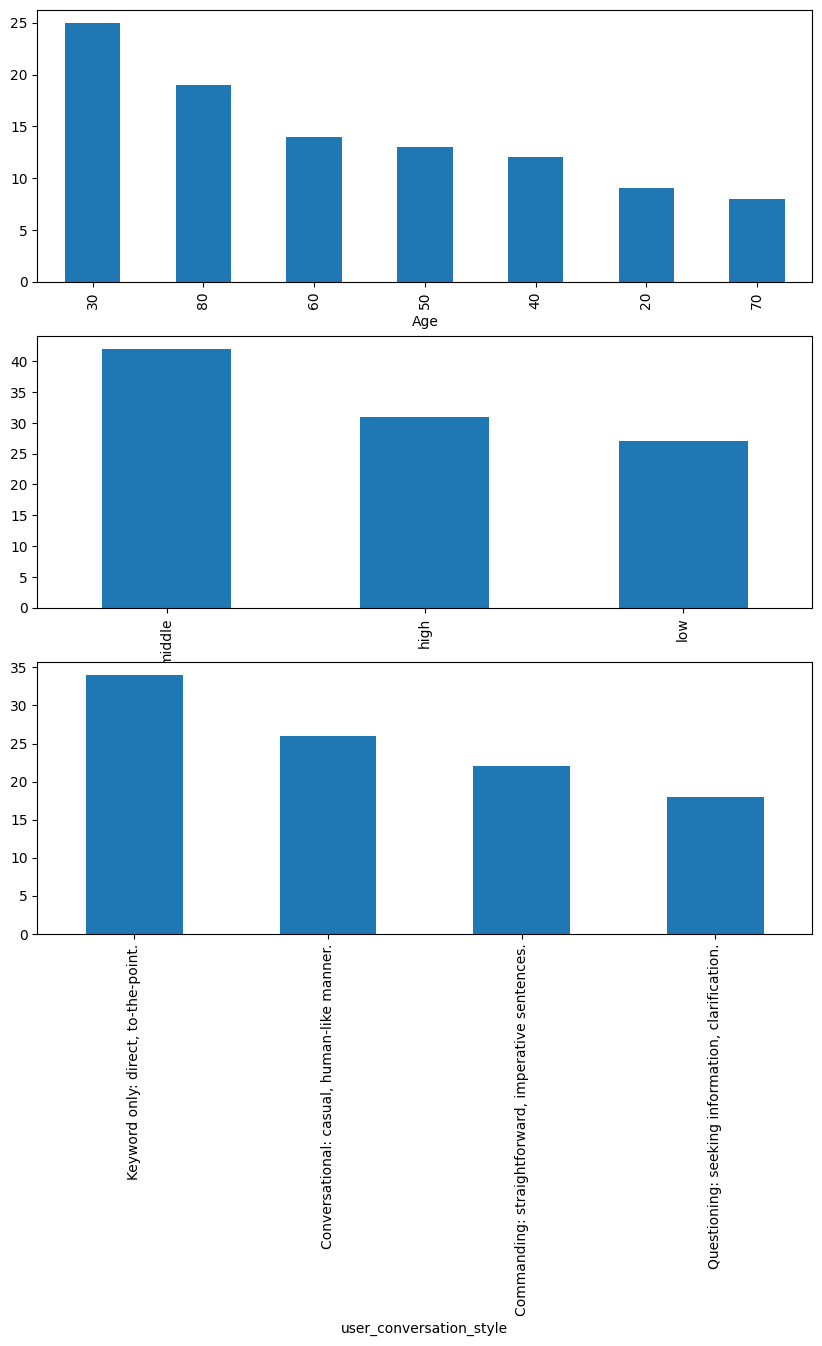

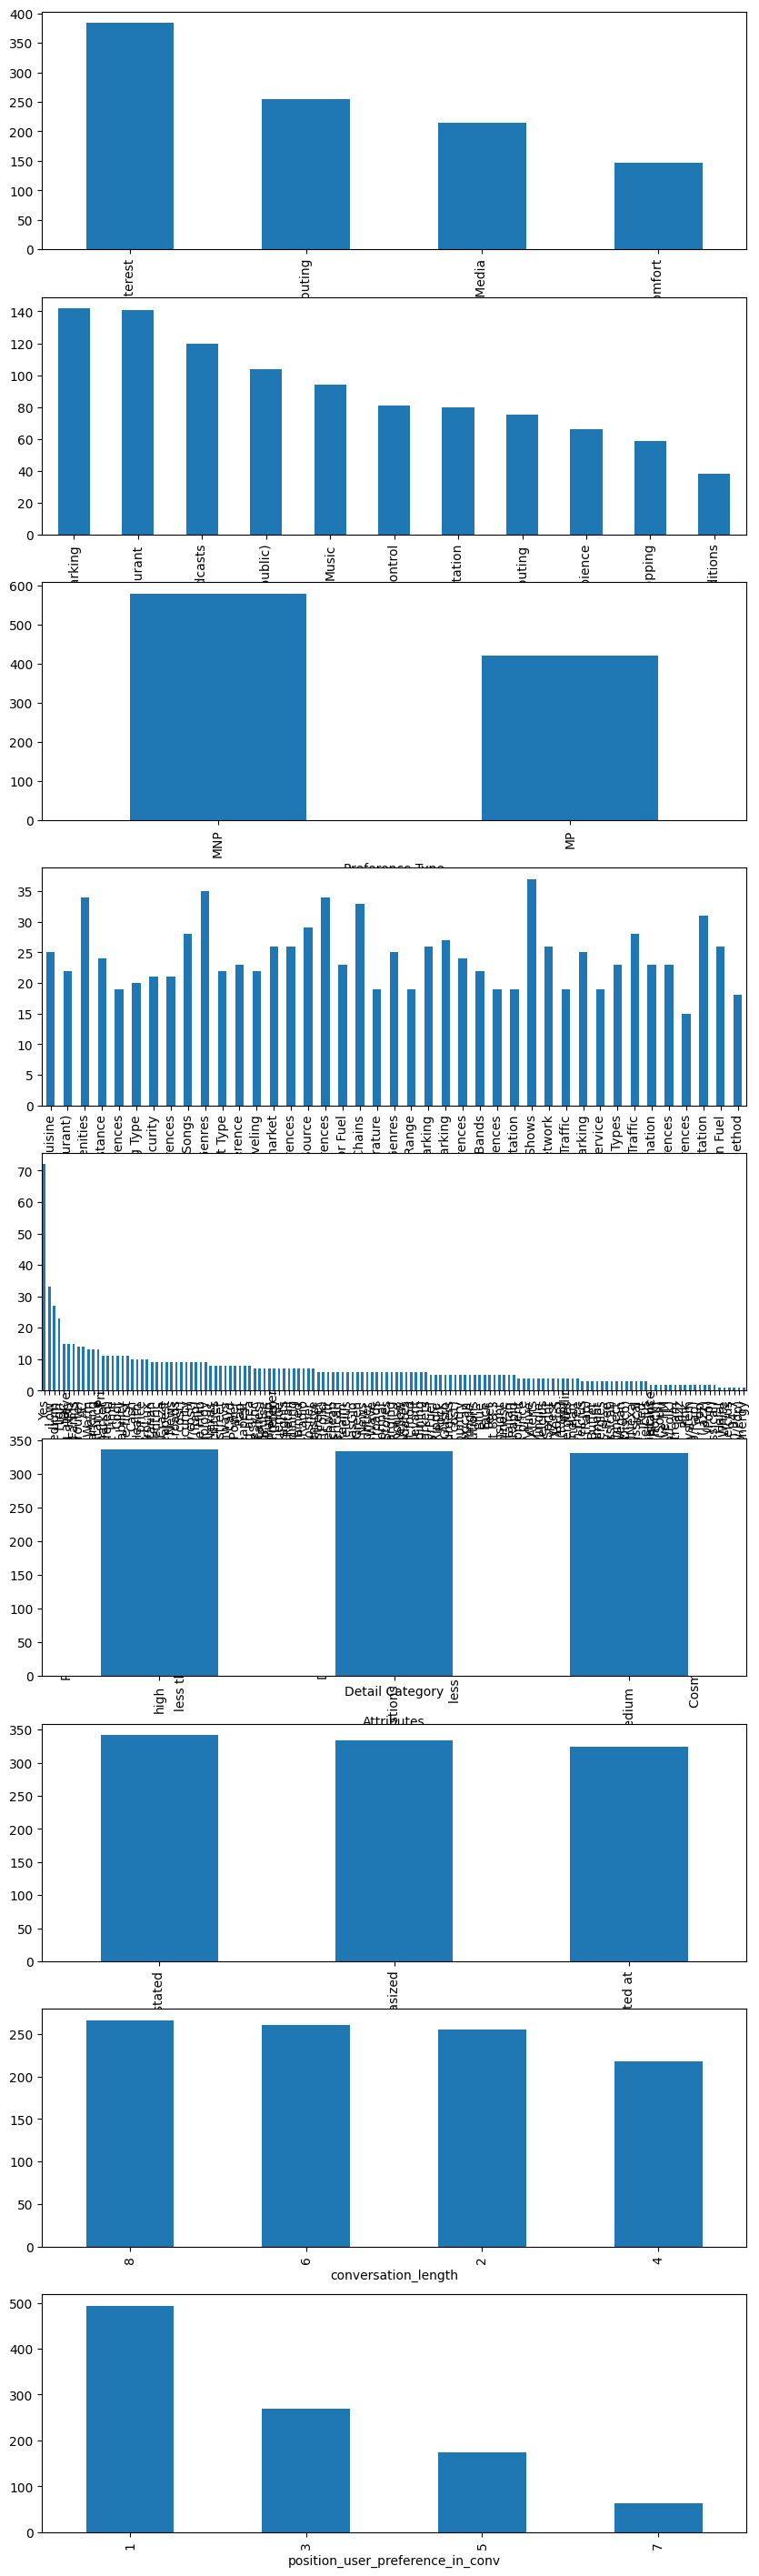

In [9]:
import matplotlib.pyplot as plt

# Metadata Plotting
counts_user_level = {
    "Age": df_user_level["Age"].value_counts(),
    "Technological_Proficiency": df_user_level["Technological_Proficiency"].value_counts(),
    "user_conversation_style": df_user_level["user_conversation_style"].value_counts()
}
counts_conversation_level = {
    "Main Category": df_conversation_level["Main Category"].value_counts(),
    "Subcategory": df_conversation_level["Subcategory"].value_counts(),
    "Preference Type": df_conversation_level["Preference Type"].value_counts(),
    "Detail Category": df_conversation_level["Detail Category"].value_counts(sort=False),
    "Attributes": df_conversation_level["Attributes"].value_counts(),
    "level_of_proactivity_assistant": df_conversation_level["level_of_proactivity_assistant"].value_counts(),
    "preference_strength_modulation": df_conversation_level["preference_strength_modulation"].value_counts(),
    "conversation_length": df_conversation_level["conversation_length"].value_counts(),
    "position_user_preference_in_conv": df_conversation_level["position_user_preference_in_conv"].value_counts(),
}
print(counts_user_level)
print(counts_conversation_level)

fig_usr, axs_usr = plt.subplots(len(counts_user_level), 1, figsize=(10, 4*len(counts_user_level)))
for idx, (k,v) in enumerate(counts_user_level.items()):
    v.plot.bar(ax=axs_usr[idx])

fig_conv, axs_conv = plt.subplots(len(counts_conversation_level), 1, figsize=(10, 4*len(counts_conversation_level)))
for idx, (k,v) in enumerate(counts_conversation_level.items()):
    v.plot.bar(ax=axs_conv[idx])

    


/var/folders/c8/06wjws915430jjknfbbm37fc0000gn/T/ipykernel_120/2984210922.py:71: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


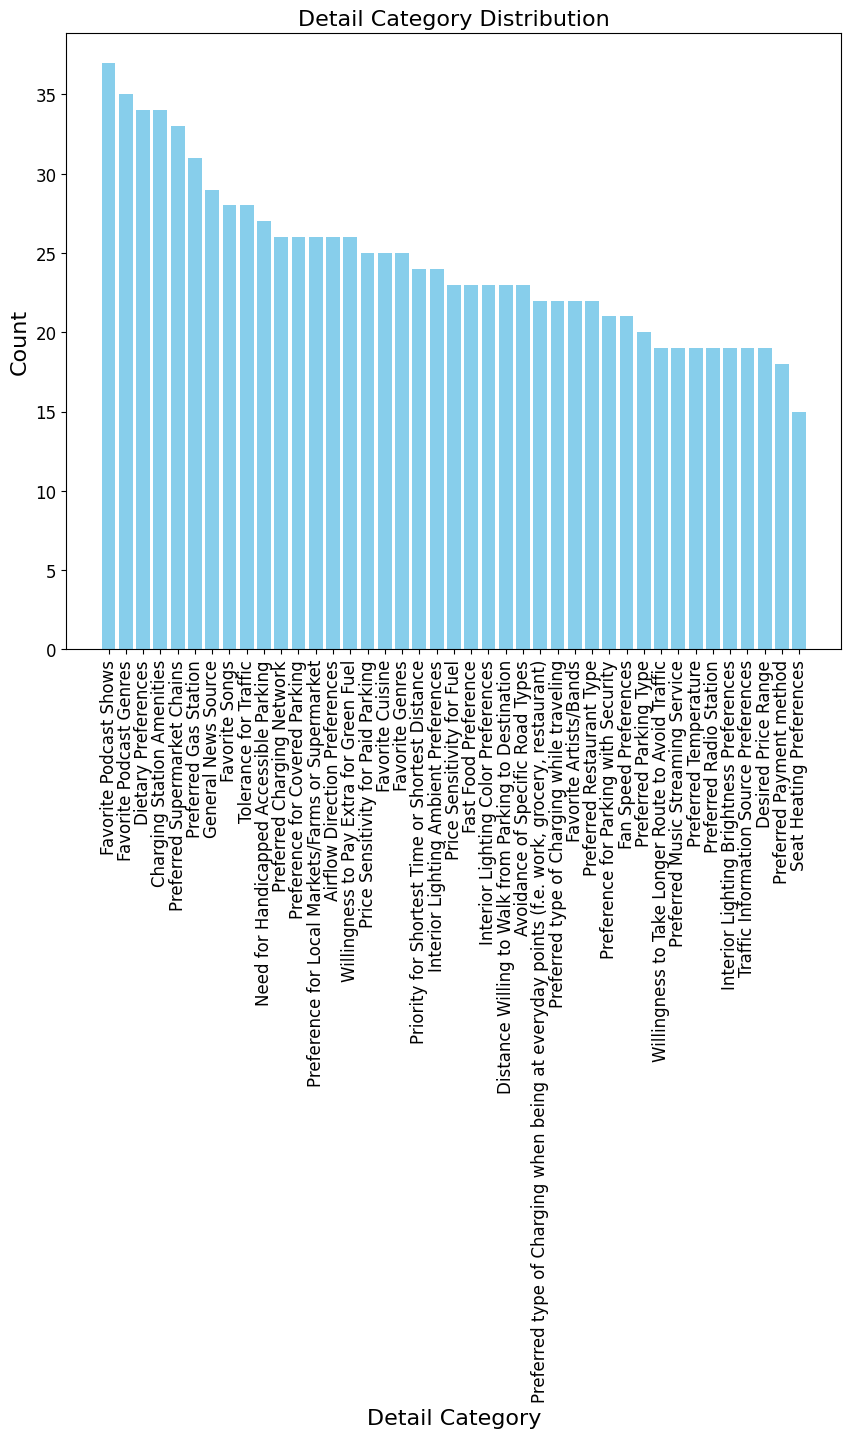

In [5]:
import matplotlib.pyplot as plt

# Example counts_conversation_level dictionary
counts_conversation_level = {
    "Detail Category": {
        "Favorite Podcast Shows": 37,
        "Favorite Podcast Genres": 35,
        "Dietary Preferences": 34,
        "Charging Station Amenities": 34,
        "Preferred Supermarket Chains": 33,
        "Preferred Gas Station": 31,
        "General News Source": 29,
        "Favorite Songs": 28,
        "Tolerance for Traffic": 28,
        "Need for Handicapped Accessible Parking": 27,
        "Preferred Charging Network": 26,
        "Preference for Covered Parking": 26,
        "Preference for Local Markets/Farms or Supermarket": 26,
        "Airflow Direction Preferences": 26,
        "Willingness to Pay Extra for Green Fuel": 26,
        "Price Sensitivity for Paid Parking": 25,
        "Favorite Cuisine": 25,
        "Favorite Genres": 25,
        "Priority for Shortest Time or Shortest Distance": 24,
        "Interior Lighting Ambient Preferences": 24,
        "Price Sensitivity for Fuel": 23,
        "Fast Food Preference": 23,
        "Interior Lighting Color Preferences": 23,
        "Distance Willing to Walk from Parking to Destination": 23,
        "Avoidance of Specific Road Types": 23,
        "Preferred type of Charging when being at everyday points (f.e. work, grocery, restaurant)": 22,
        "Preferred type of Charging while traveling": 22,
        "Favorite Artists/Bands": 22,
        "Preferred Restaurant Type": 22,
        "Preference for Parking with Security": 21,
        "Fan Speed Preferences": 21,
        "Preferred Parking Type": 20,
        "Willingness to Take Longer Route to Avoid Traffic": 19,
        "Preferred Music Streaming Service": 19,
        "Preferred Temperature": 19,
        "Preferred Radio Station": 19,
        "Interior Lighting Brightness Preferences": 19,
        "Traffic Information Source Preferences": 19,
        "Desired Price Range": 19,
        "Preferred Payment method": 18,
        "Seat Heating Preferences": 15
    }
}

# Convert the counts to a DataFrame
df_detail_category = pd.DataFrame(list(counts_conversation_level["Detail Category"].items()), columns=['Detail Category', 'Count'])

# Plotting "Detail Category"
fig, ax = plt.subplots(figsize=(10, 8))

ax.bar(df_detail_category["Detail Category"], df_detail_category["Count"], color='skyblue')

# Customizing the plot
ax.set_title("Detail Category Distribution", fontsize=16)
ax.set_xlabel("Detail Category", fontsize=16)
ax.set_ylabel("Count", fontsize=16)
ax.tick_params(axis='x', labelsize=12, rotation=90)
ax.tick_params(axis='y', labelsize=12)

# Removing underscores and setting labels vertically
labels = [label.replace('_', ' ') for label in df_detail_category["Detail Category"]]
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels, rotation=90)

# Save the plot as a PDF
plt.tight_layout()
plt.savefig("detail_category_distribution.pdf")
plt.show()

In [10]:
import matplotlib.pyplot as plt

# Means Statistical Values
means_user_level = {
    "Age": df_user_level["Age"].mean(),
}
means_conversation_level = {
    "conversation_length": df_conversation_level["conversation_length"].mean(),
    "position_user_preference_in_conv": df_conversation_level["position_user_preference_in_conv"].mean(),
    "sentences_of_conversation": df_conversation_level["sentences_of_conversation"].mean(),
    "sentences_per_turn": df_conversation_level["sentences_per_turn"].mean(),
    "words_of_conversation": df_conversation_level["words_of_conversation"].mean(),
    "words_per_turn": df_conversation_level["words_per_turn"].mean(),
    "tokens_of_conversation": df_conversation_level["tokens_of_conversation"].mean(),
    "tokens_per_turn": df_conversation_level["tokens_per_turn"].mean(),
    "sentences_of_next_conv_question": df_conversation_level["sentences_of_next_conv_question"].mean(),
    "words_of_next_conv_question": df_conversation_level["words_of_next_conv_question"].mean(),
    "tokens_of_next_conv_question": df_conversation_level["tokens_of_next_conv_question"].mean(),

    "sentences_of_maintenance_questions_per_question": df_conversation_level["sentences_of_maintenance_questions_per_question"].mean(),
    "words_of_maintenance_questions_per_question": df_conversation_level["words_of_maintenance_questions_per_question"].mean(),
    "tokens_of_maintenance_questions_per_question": df_conversation_level["tokens_of_maintenance_questions_per_question"].mean(),
}
print(means_user_level)
print(means_conversation_level)

{'Age': 49.8}
{'conversation_length': 5.076, 'position_user_preference_in_conv': 2.61, 'sentences_of_conversation': 8.667, 'sentences_per_turn': 1.701125, 'words_of_conversation': 80.781, 'words_per_turn': 16.500083333333333, 'tokens_of_conversation': 97.852, 'tokens_per_turn': 19.954208333333337, 'sentences_of_next_conv_question': 1.044, 'words_of_next_conv_question': 8.34, 'tokens_of_next_conv_question': 9.676, 'sentences_of_maintenance_questions_per_question': 1.4693333333333332, 'words_of_maintenance_questions_per_question': 12.748333333333333, 'tokens_of_maintenance_questions_per_question': 15.580333333333332}


In [11]:
# automatic evaluation
# conversation length correct
correct_counter = 0
incorrect_counter = 0
incorrect_counter_2 = 0
incorrect_counter_4 = 0
incorrect_counter_6 = 0
incorrect_counter_8 = 0

for line in train_dataset_lines:
    for conversation_data in line["data"]:
        expected_conversation_length = int(conversation_data["meta_info"]["conversation_length"])
        if len(conversation_data["extraction_conversation"]) == expected_conversation_length:
            correct_counter += 1
        else:
            incorrect_counter += 1
            if expected_conversation_length == 2:
                incorrect_counter_2 += 1
            elif expected_conversation_length == 4:
                incorrect_counter_4 += 1
            elif expected_conversation_length == 6:
                incorrect_counter_6 += 1
            elif expected_conversation_length == 8:
                incorrect_counter_8 += 1
            

In [12]:
print(incorrect_counter)
print(incorrect_counter_8)
print(incorrect_counter_6)
print(incorrect_counter_4)
print(incorrect_counter_2)

40
29
9
0
2


In [13]:
# attribute string in conversation

string_in_conversation_counter = 0
string_in_conversation_counter_user_only = 0

for line in train_dataset_lines:
    for conversation_data in line["data"]:
        concat_conversation = " ".join([str(list(turn.values())[0]) for turn in conversation_data["extraction_conversation"]])
        concat_conversation_user_only = " ".join([str(list(turn.values())[0]) for turn in conversation_data["extraction_conversation"][::2]])
        preference = conversation_data["user_preference"].split(";")[-1].strip()
        if preference.lower() in concat_conversation.lower():
            string_in_conversation_counter += 1
        if preference.lower() in concat_conversation_user_only.lower():
            string_in_conversation_counter_user_only += 1

In [14]:
print(string_in_conversation_counter)
print(string_in_conversation_counter_user_only)

680
600
